## Current Status:
Working on this as a side project aiming to learn about DQN and RL. Will keep on improving and try to make it work.

## Goal:
To train a DQN to draw an MNIST digit on a blank canvas. <br>
As someone who has worked on GANs a lot, it struct to me that GANs generate images in one-shot, as opposed to humans, who draw in a sequential manner. Hence I try to use RL in order to experiment if DQN can generate/draw an MNIST digit by taking a sequence of steps on a blank canvas.


## References:
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- https://github.com/pytorch/examples/blob/master/mnist/main.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces

import torch
from torch import nn, optim
import torch.nn.functional as F

import os
import random
import math
from collections import namedtuple
from itertools import count

In [2]:
class RewardModel(nn.Module):
    def __init__(self):
        super(RewardModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
class CanvasEnv(gym.Env):
    def __init__(self, digit):
        super(CanvasEnv, self).__init__()
        self.digit = digit
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=1, shape=(28, 28), dtype=int)
        
        self.canvas = np.zeros((28, 28))
        self.old_canvas = self.canvas.copy()
        
        self.action_map = {
            0: "left",
            1: "up",
            2: "right",
            3: "bottom",
            4: "stop"
        }
        
        self.reward_model = RewardModel()
        self.reward_model.load_state_dict(torch.load("reward_model/model.pt"))
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.reward_model.double().to(self.device)
        self.reward_model.eval()
        
    def step(self, action):
        done = False
        beyond_limit = False
        self.old_canvas = self.canvas.copy()
        
        if self.action_map[action] == "left":
            if self.y == 0:
                beyond_limit = True
            self.y = max(0, self.y-1)
        elif self.action_map[action] == "right":
            if self.y == 27:
                beyond_limit = True
            self.y = min(27, self.y+1)
        elif self.action_map[action] == "up":
            if self.x == 0:
                beyond_limit = True
            self.x = max(0, self.x-1)
        elif self.action_map[action] == "down":
            if self.x == 27:
                beyond_limit = True
            self.x = min(27, self.x+1)
        elif self.action_map[action] == "stop":
            done = True
            
        self.canvas[self.x, self.y] = 1
        
        reward_model_input = torch.from_numpy(self.canvas).view(1, 1, 28, 28).double().to(self.device)
        reward_model_output = self.reward_model(reward_model_input)
        reward = torch.exp(reward_model_output.squeeze()[self.digit]).cpu().detach().numpy()
        reward = np.reshape(reward, (1,))
        if np.sum(self.canvas - self.old_canvas) == 0:
            reward -= 1
        if beyond_limit:
            reward -= 1
        reward[reward >= 0.5] += 5
#         reward[reward < 0.3] = 0
        
        return self.as_tensor(np.concatenate([self.old_canvas, self.canvas])), reward, done
    
    def reset(self):
        self.canvas = np.zeros((28, 28))
        self.x, self.y = 5, 5
        self.old_canvas = self.canvas.copy()
        self.canvas[self.x, self.y] = 1
        return self.as_tensor(np.concatenate([self.old_canvas, self.canvas]))
    
    def render(self):
        plt.imshow(self.canvas)
        plt.show()
        
    def as_tensor(self, array):
        array = np.reshape(array, [1, 2, 28, 28])
        return torch.from_numpy(array).double().to(self.device)

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):
    def __init__(self, nb_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, nb_actions)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

DIGIT = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

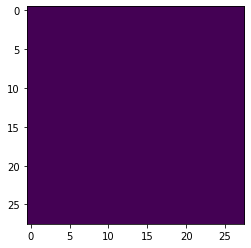

In [8]:
env = CanvasEnv(DIGIT)
env.render()

In [9]:
nb_actions = env.action_space.n

In [10]:
policy_net = DQN(nb_actions).double().to(device)
target_net = DQN(nb_actions).double().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [11]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [12]:
steps_done = 0

def select_action(state):
#     state = np.reshape(state, [1, 1, 28, 28])
#     state = torch.from_numpy(state).double().to(device)
    
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1]
    else:
        return torch.tensor([random.randrange(nb_actions)], device=device, dtype=torch.long)

In [13]:
episode_durations = list()

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Eposide')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        print("Not Enough Samples in Memory")
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
#     for a in batch.action:
#         print(a.shape)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
#     print(policy_net(state_batch).shape, action_batch.shape)
    state_action_values = policy_net(state_batch).gather(1, action_batch.view(-1, 1))
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device).double()
#     print(target_net(non_final_next_states).dtype, next_state_values.dtype, non_final_mask.dtype)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Running Episode 1/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


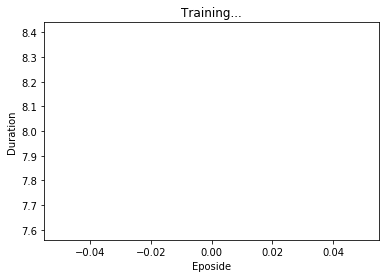

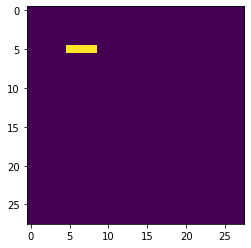

Running Episode 2/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


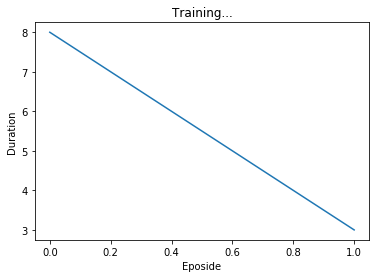

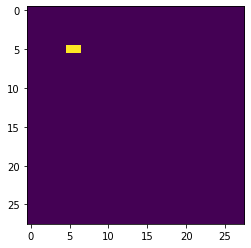

Running Episode 3/300
Not Enough Samples in Memory


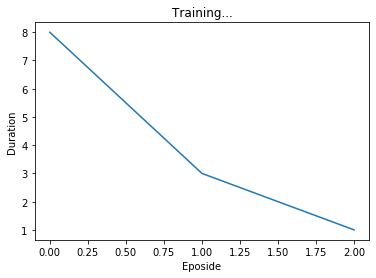

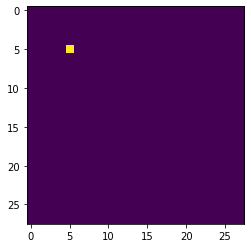

Running Episode 4/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


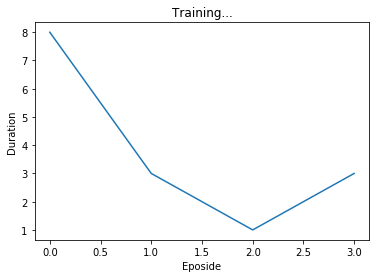

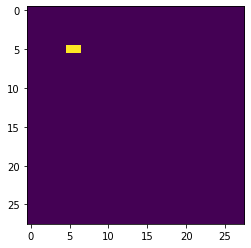

Running Episode 5/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


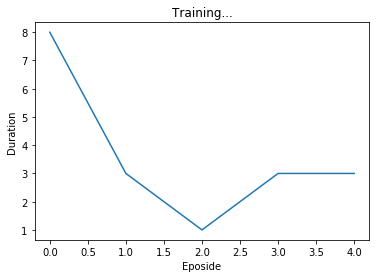

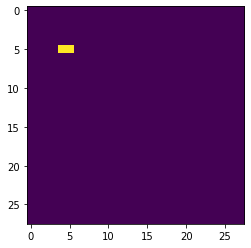

Running Episode 6/300
Not Enough Samples in Memory


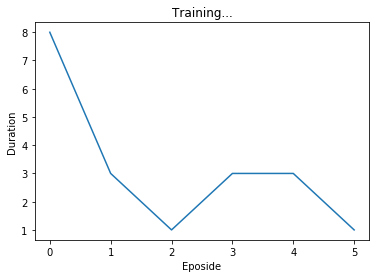

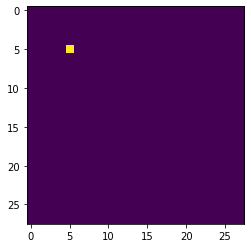

Running Episode 7/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


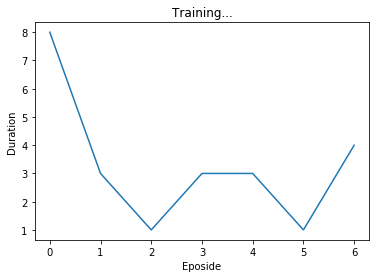

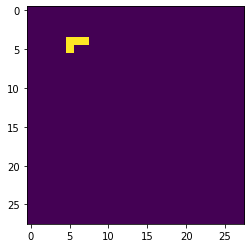

Running Episode 8/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


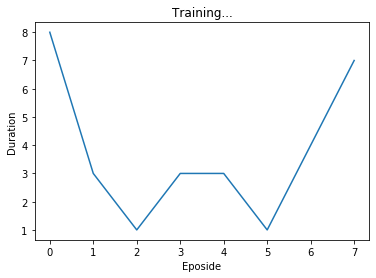

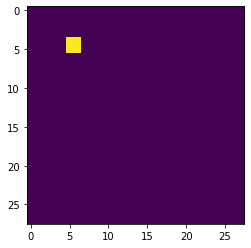

Running Episode 9/300
Not Enough Samples in Memory


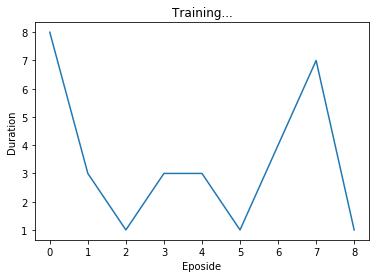

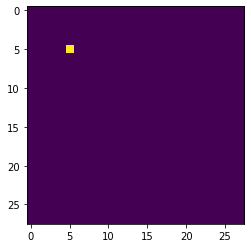

Running Episode 10/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


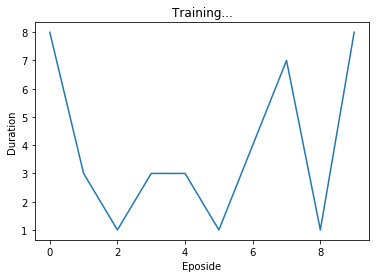

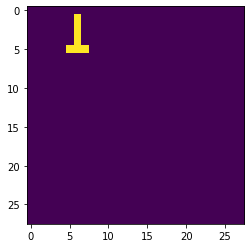

Running Episode 11/300
Not Enough Samples in Memory
Not Enough Samples in Memory


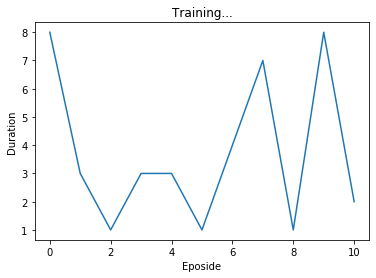

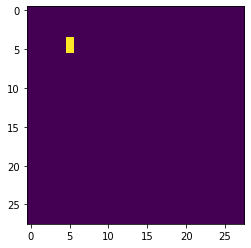

Running Episode 12/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


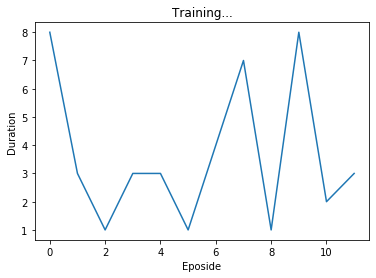

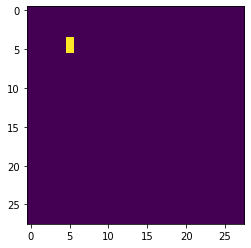

Running Episode 13/300
Not Enough Samples in Memory
Not Enough Samples in Memory


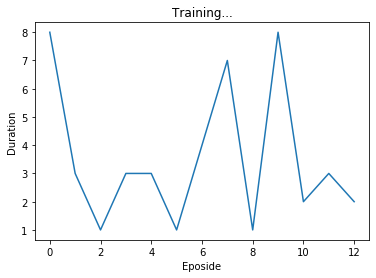

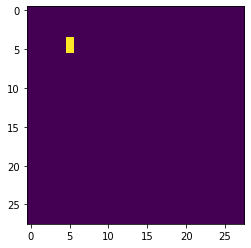

Running Episode 14/300
Not Enough Samples in Memory


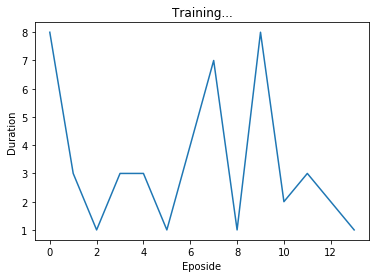

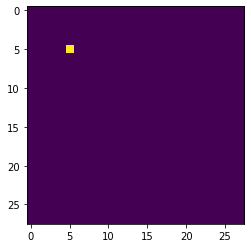

Running Episode 15/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


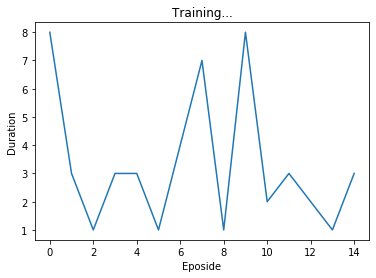

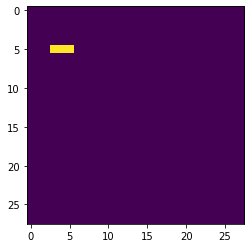

Running Episode 16/300
Not Enough Samples in Memory


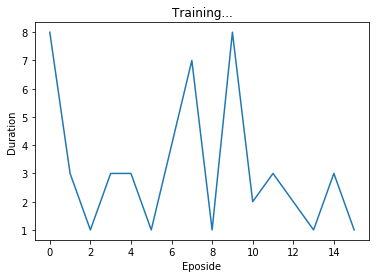

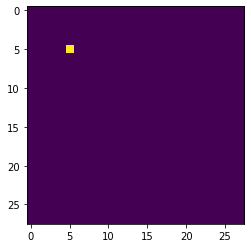

Running Episode 17/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


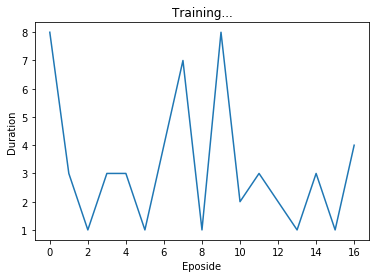

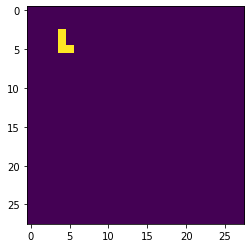

Running Episode 18/300
Not Enough Samples in Memory


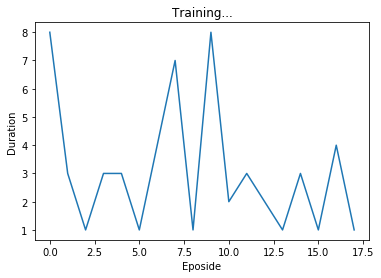

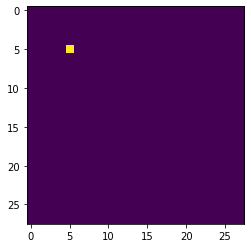

Running Episode 19/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


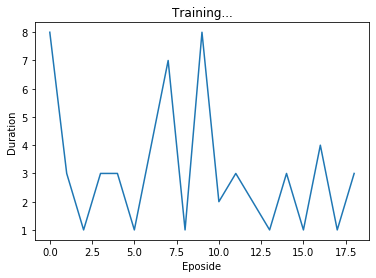

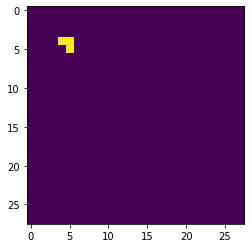

Running Episode 20/300
Not Enough Samples in Memory


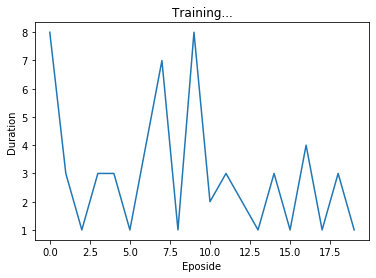

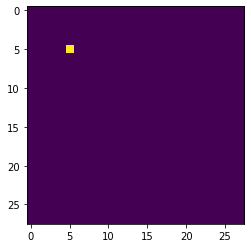

Running Episode 21/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


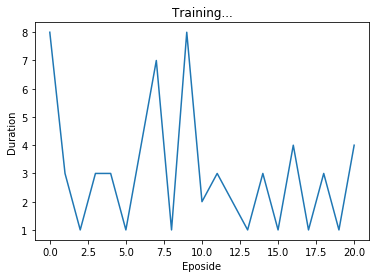

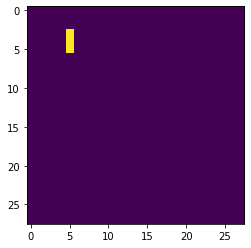

Running Episode 22/300
Not Enough Samples in Memory
Not Enough Samples in Memory


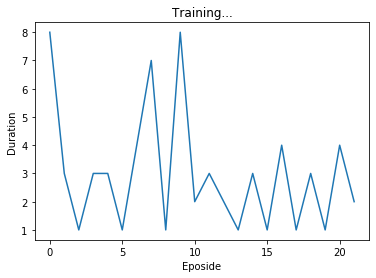

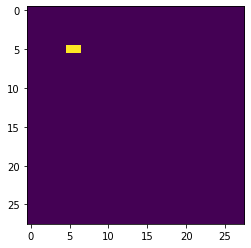

Running Episode 23/300
Not Enough Samples in Memory


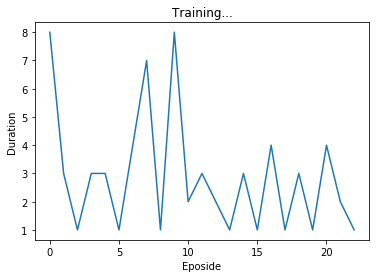

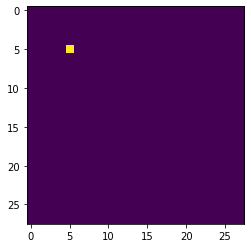

Running Episode 24/300
Not Enough Samples in Memory


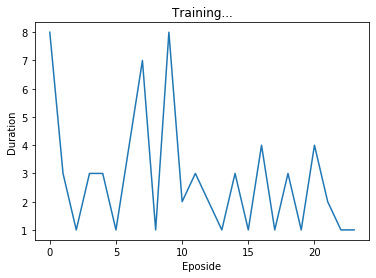

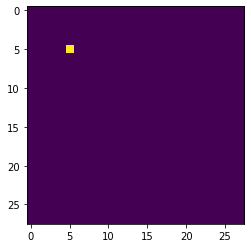

Running Episode 25/300
Not Enough Samples in Memory


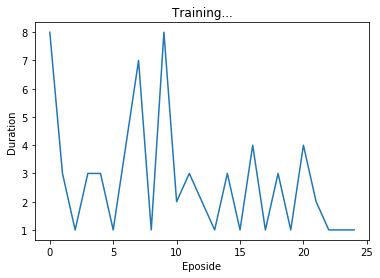

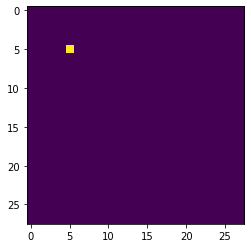

Running Episode 26/300
Not Enough Samples in Memory


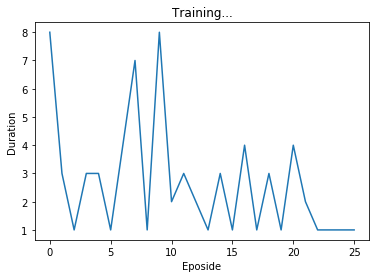

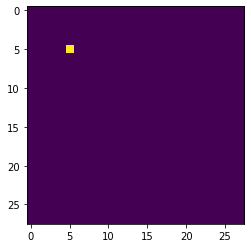

Running Episode 27/300
Not Enough Samples in Memory


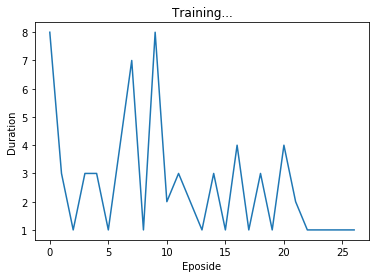

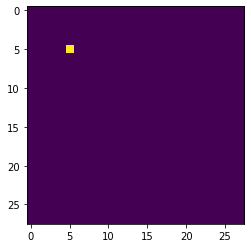

Running Episode 28/300
Not Enough Samples in Memory
Not Enough Samples in Memory


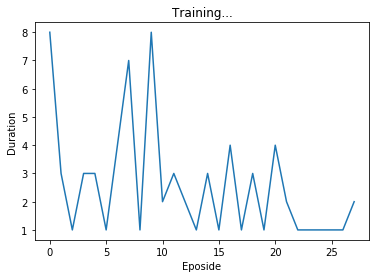

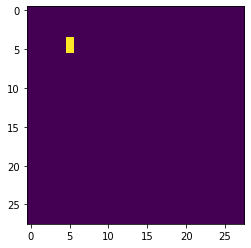

Running Episode 29/300
Not Enough Samples in Memory


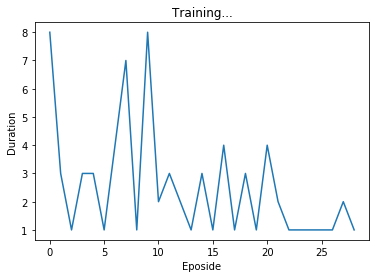

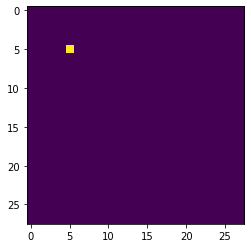

Running Episode 30/300
Not Enough Samples in Memory
Not Enough Samples in Memory


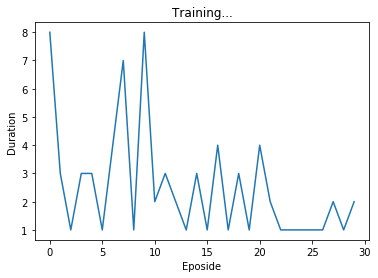

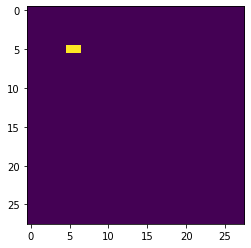

Running Episode 31/300
Not Enough Samples in Memory


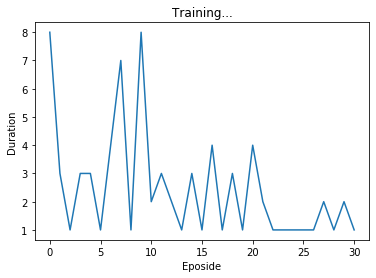

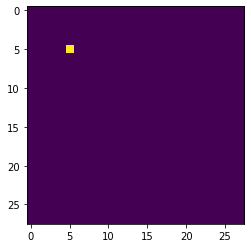

Running Episode 32/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


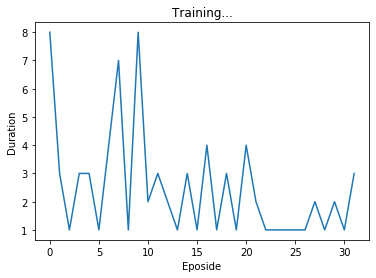

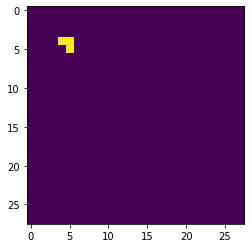

Running Episode 33/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


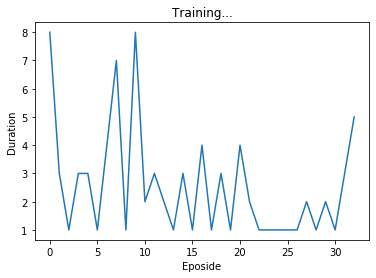

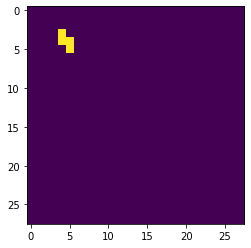

Running Episode 34/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


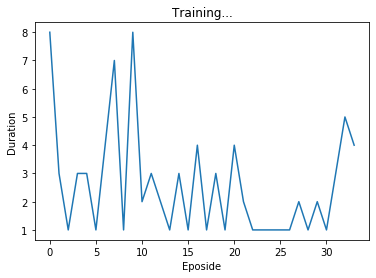

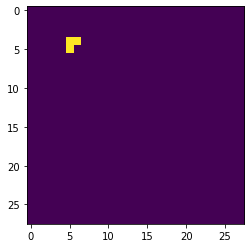

Running Episode 35/300
Not Enough Samples in Memory
Not Enough Samples in Memory


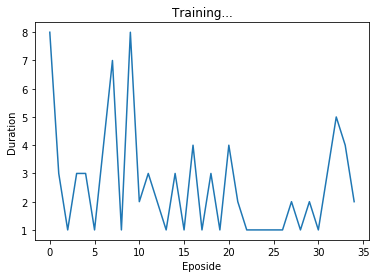

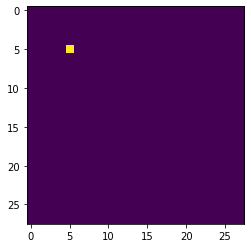

Running Episode 36/300
Not Enough Samples in Memory


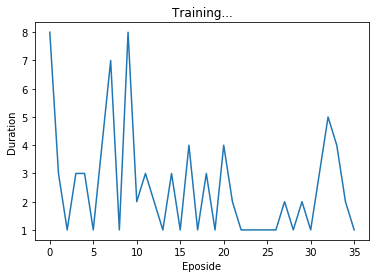

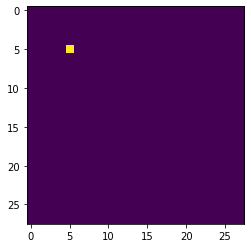

Running Episode 37/300
Not Enough Samples in Memory
Not Enough Samples in Memory


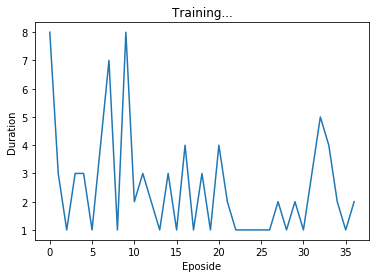

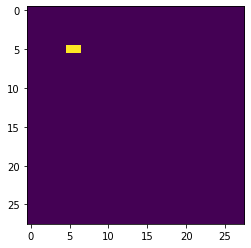

Running Episode 38/300
Not Enough Samples in Memory
Not Enough Samples in Memory


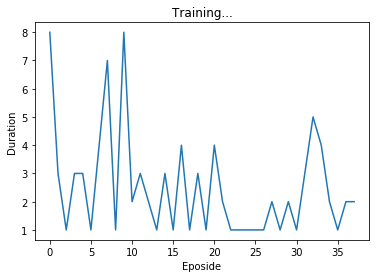

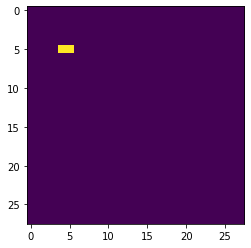

Running Episode 39/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


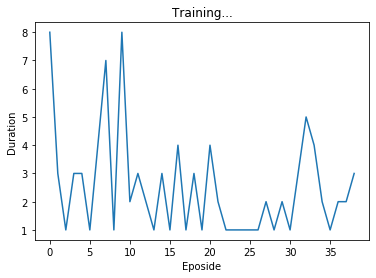

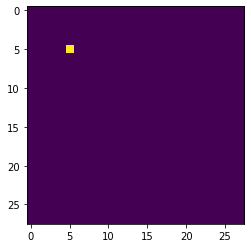

Running Episode 40/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


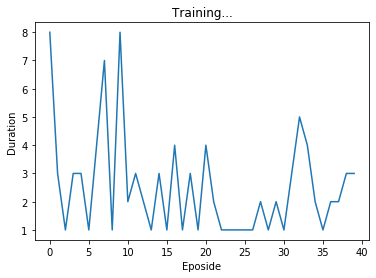

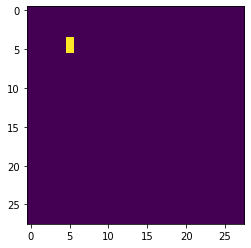

Running Episode 41/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


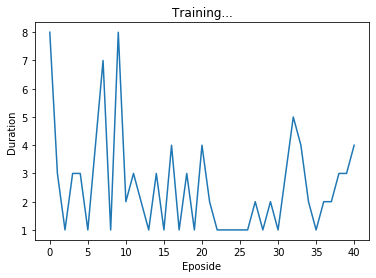

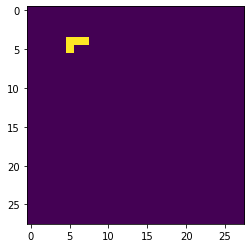

Running Episode 42/300
Not Enough Samples in Memory


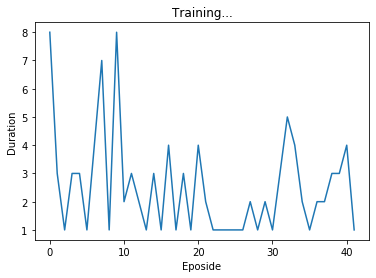

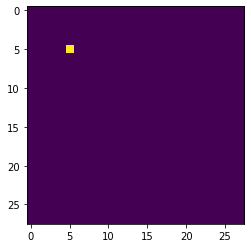

Running Episode 43/300
Not Enough Samples in Memory


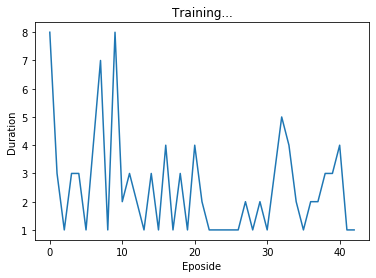

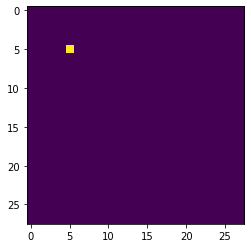

Running Episode 44/300
Not Enough Samples in Memory


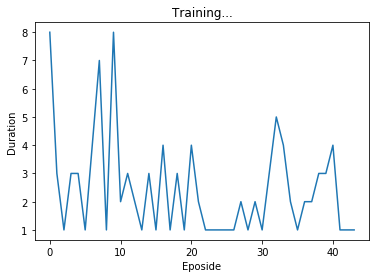

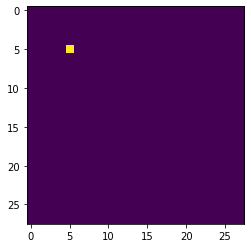

Running Episode 45/300
Not Enough Samples in Memory


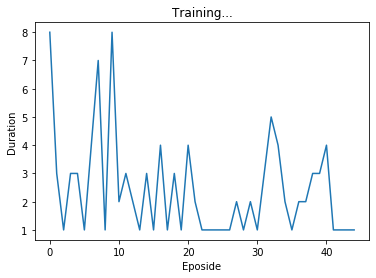

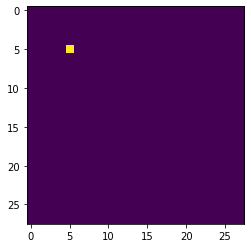

Running Episode 46/300
Not Enough Samples in Memory


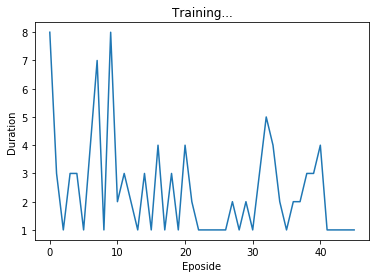

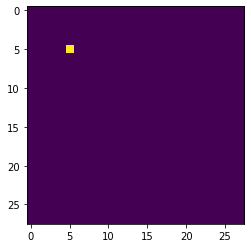

Running Episode 47/300
Not Enough Samples in Memory
Not Enough Samples in Memory


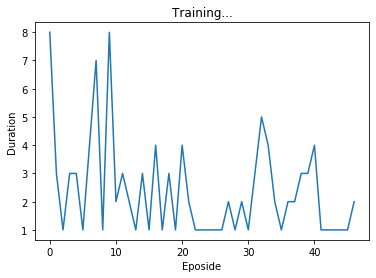

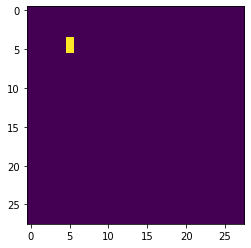

Running Episode 48/300
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


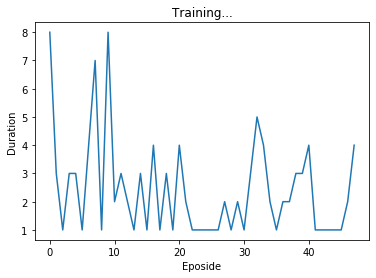

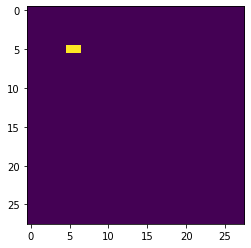

Running Episode 49/300
Not Enough Samples in Memory


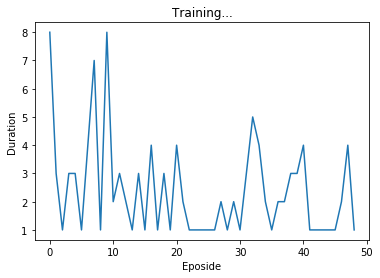

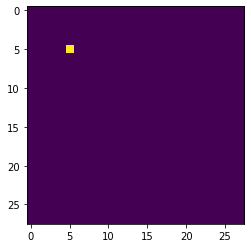

Running Episode 50/300
Not Enough Samples in Memory


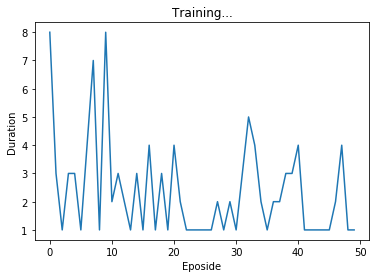

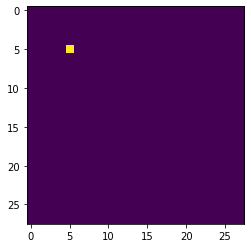

Running Episode 51/300
Not Enough Samples in Memory


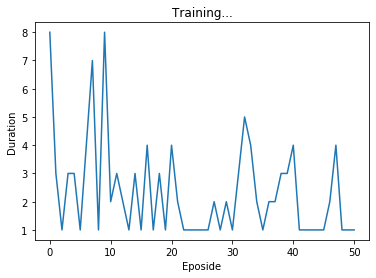

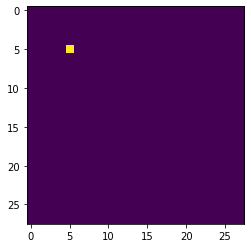

Running Episode 52/300
Not Enough Samples in Memory


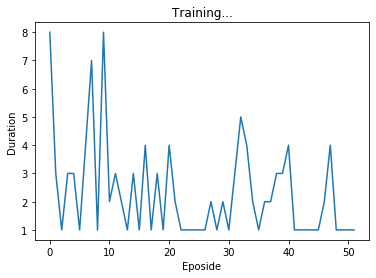

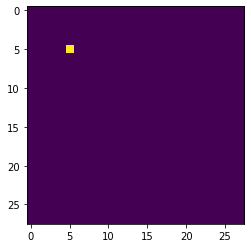

Running Episode 53/300
Not Enough Samples in Memory


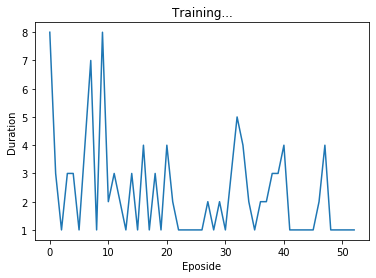

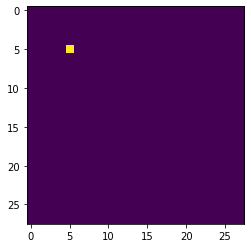

Running Episode 54/300
Not Enough Samples in Memory


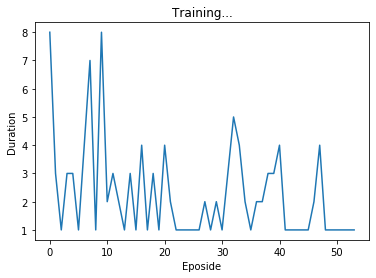

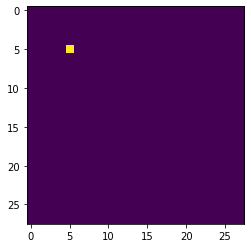

Running Episode 55/300
Not Enough Samples in Memory


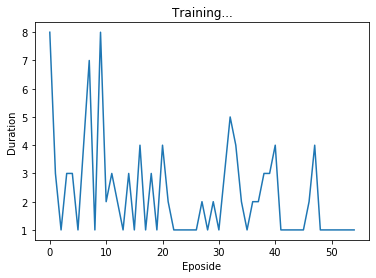

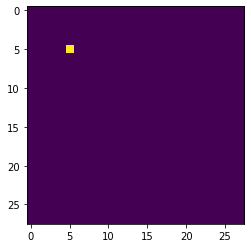

Running Episode 56/300
Not Enough Samples in Memory


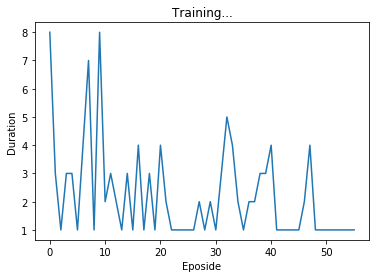

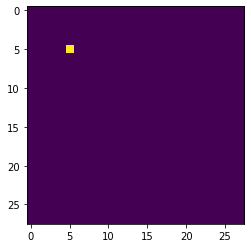

Running Episode 57/300
Not Enough Samples in Memory


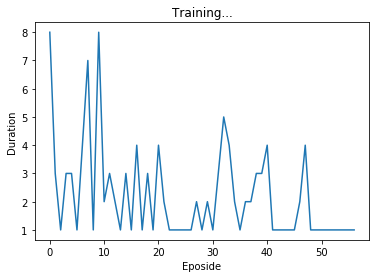

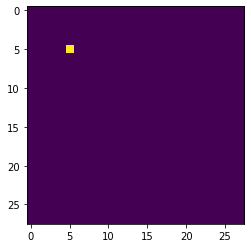

Running Episode 58/300
Not Enough Samples in Memory


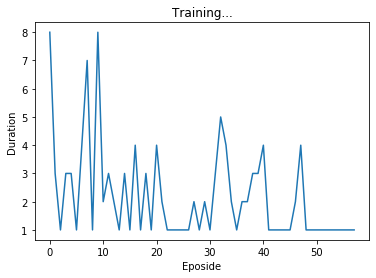

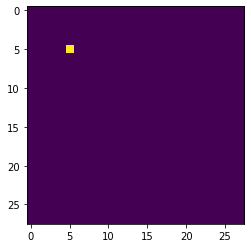

Running Episode 59/300


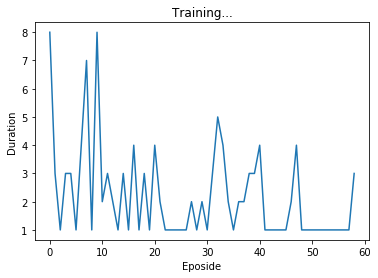

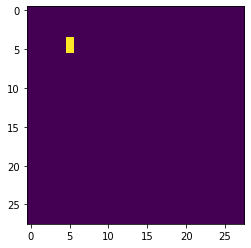

Running Episode 60/300


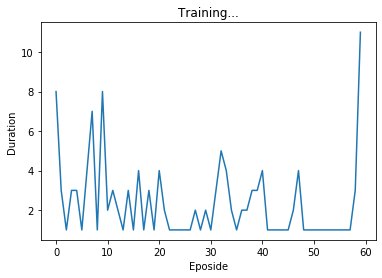

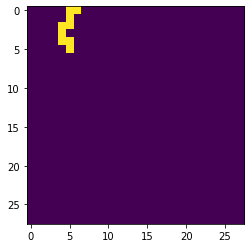

Running Episode 61/300


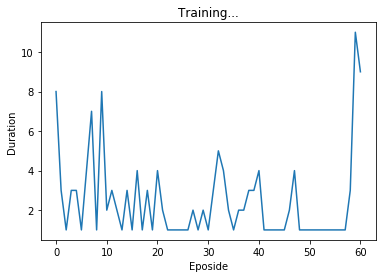

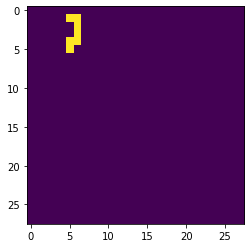

Running Episode 62/300


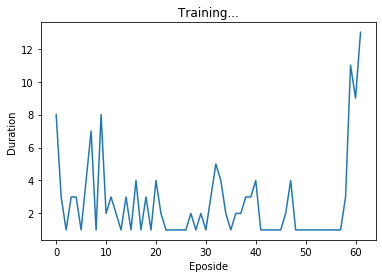

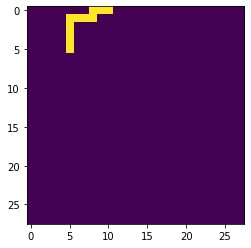

Running Episode 63/300


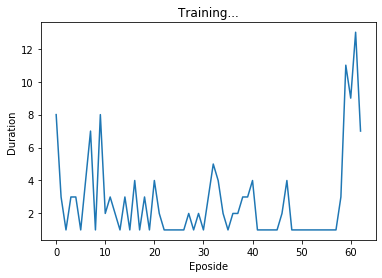

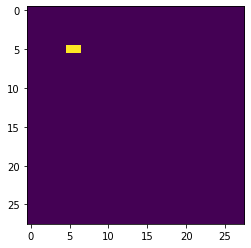

Running Episode 64/300


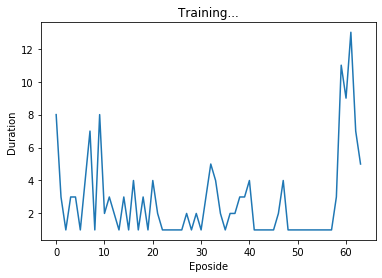

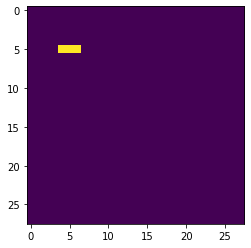

Running Episode 65/300


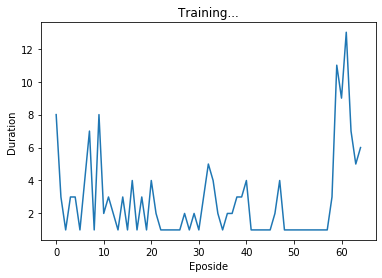

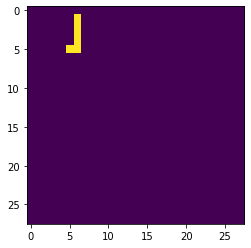

Running Episode 66/300


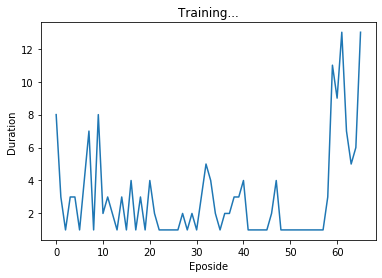

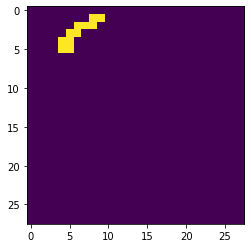

Running Episode 67/300


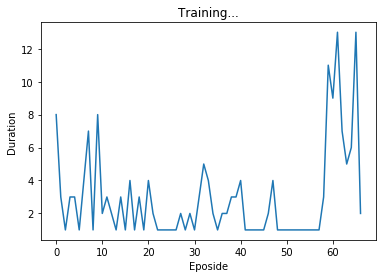

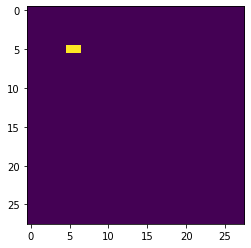

Running Episode 68/300


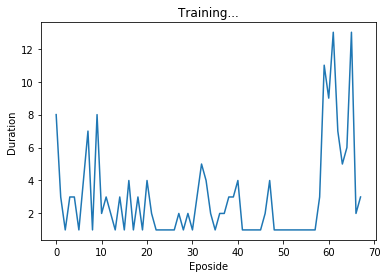

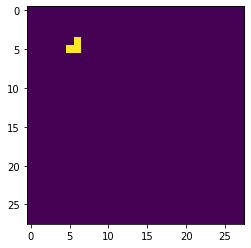

Running Episode 69/300


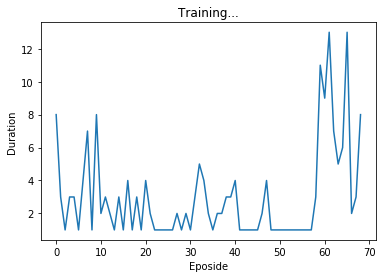

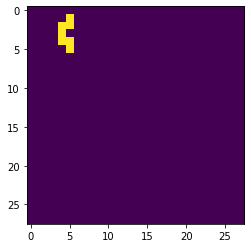

Running Episode 70/300


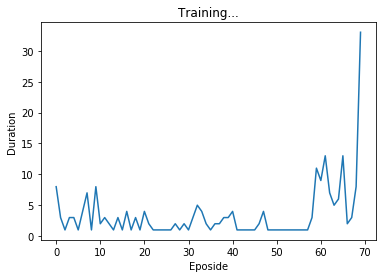

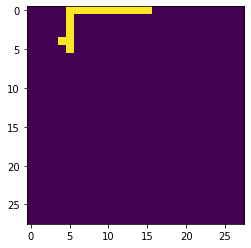

Running Episode 71/300


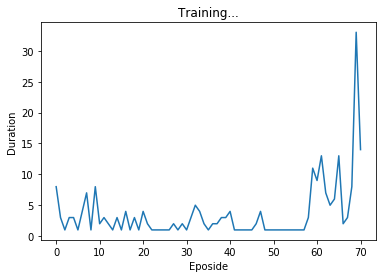

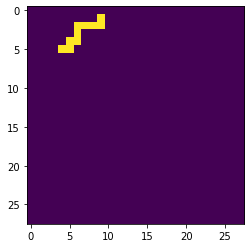

Running Episode 72/300


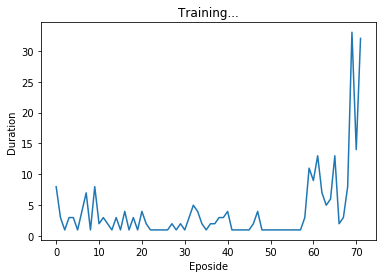

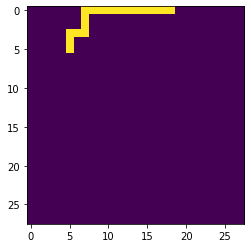

Running Episode 73/300


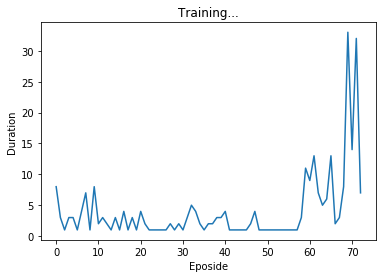

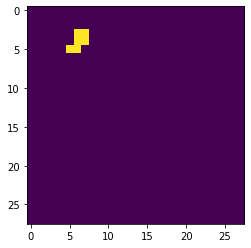

Running Episode 74/300


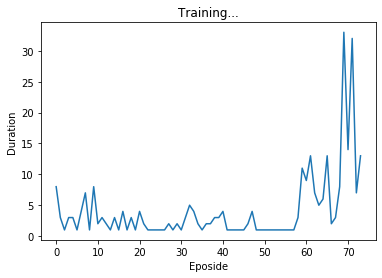

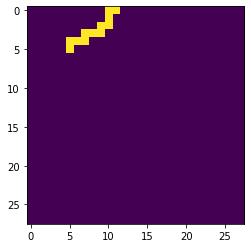

Running Episode 75/300


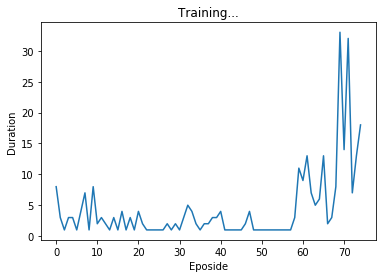

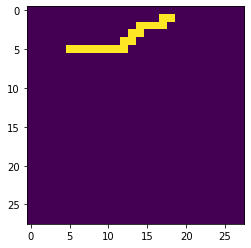

Running Episode 76/300


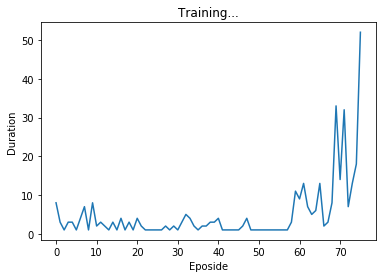

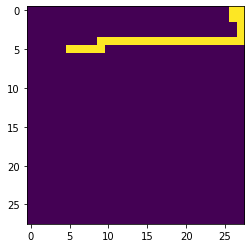

Running Episode 77/300


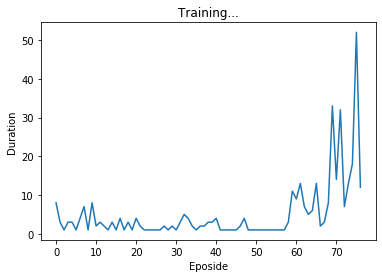

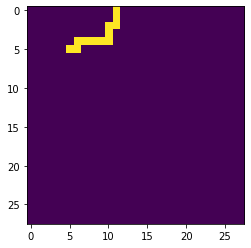

Running Episode 78/300


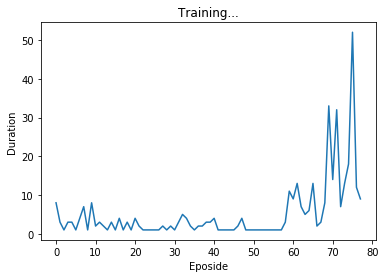

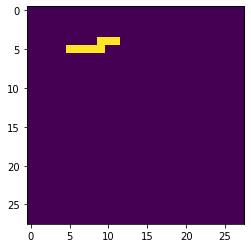

Running Episode 79/300


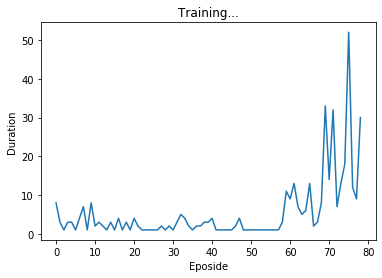

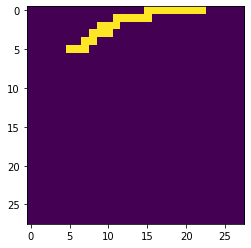

Running Episode 80/300


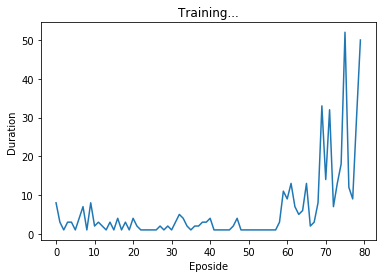

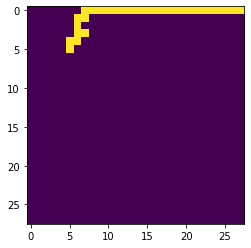

Running Episode 81/300


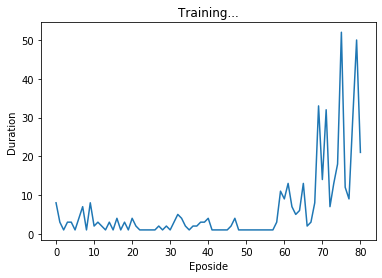

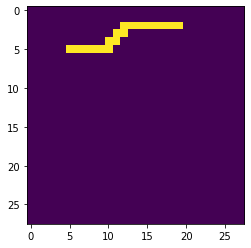

Running Episode 82/300


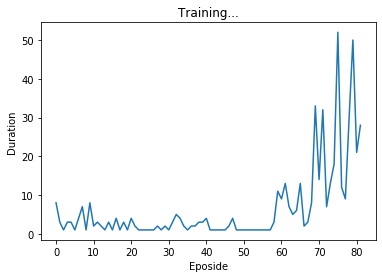

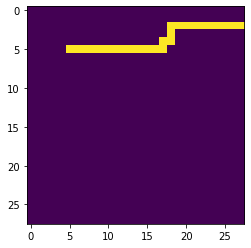

Running Episode 83/300


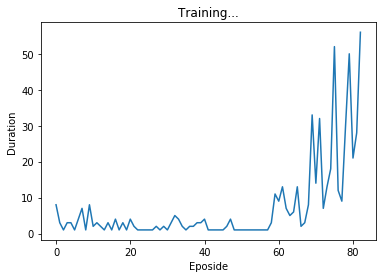

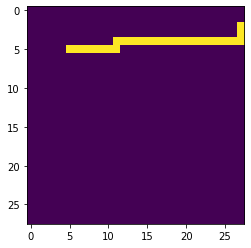

Running Episode 84/300


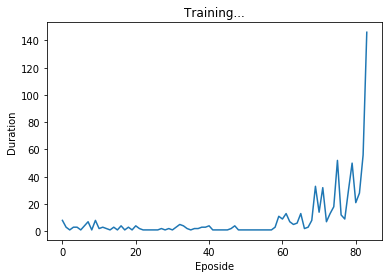

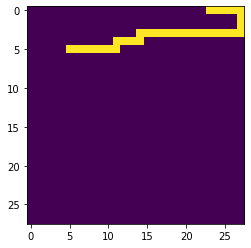

Running Episode 85/300


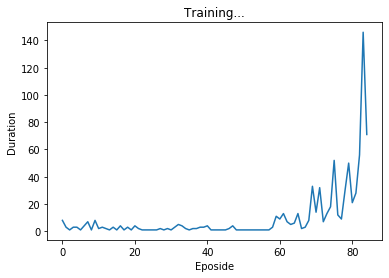

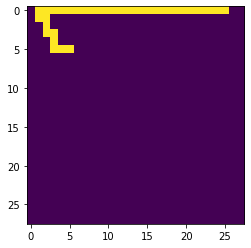

Running Episode 86/300


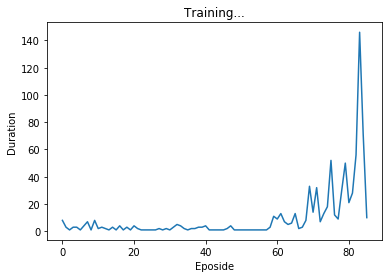

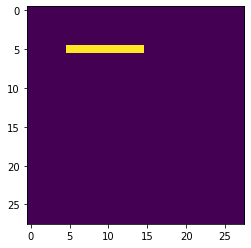

Running Episode 87/300


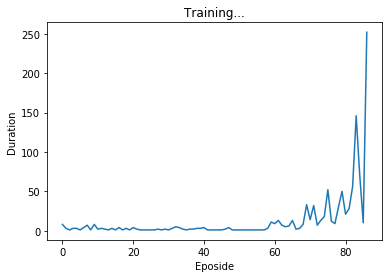

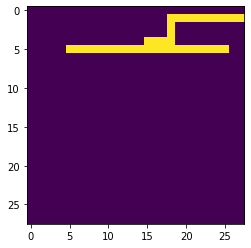

Running Episode 88/300


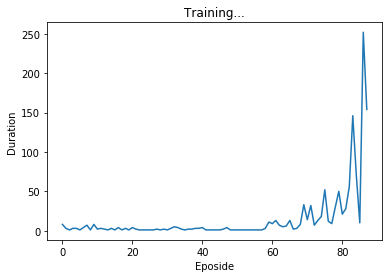

KeyboardInterrupt: 

In [15]:
num_episode = 300
for i_episode in range(1, num_episode+1):
    print("Running Episode {}/{}".format(i_episode, num_episode))
    # Initialize the environment and state
    state = env.reset()
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done = env.step(action.item())
        reward = torch.tensor(reward, device=device)
        if done:
            next_state = None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of optimization (on target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            env.render()
            break
    
    # Update the target network by copying weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()